In [1]:
import os, glob, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
#from tqdm import tqdm 
import matplotlib.pyplot as pl

#from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3739021260907784378,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11720753332808464822
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5060693856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3186482510985848023
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15350815741455313331
 physical_device_desc: "device: XLA_GPU device"]

In [4]:
tf.python.platform.build_info.build_info['cuda_version']

'64_101'

In [5]:
tf.python.platform.build_info.build_info['cudnn_version']

'64_7'

In [6]:
tf.__version__

'2.3.0'

## 1. Description of the problem and data.

The task that I tackled here is to create a deep learning model to identify metastatic cancer in small image patches taken from larger digital pathology scans.

Data characteristics for this project are stated below:
- 220,025 training images

- 57,456 test images

- each image has 96x96 pixels

- images are in tif format

In [7]:
train_dirname = "./histopathologic-cancer-detection/train/"

In [8]:
train_labels = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [9]:
# Convert the train images
if False:
    for image in list(train_labels['id']):
        fname = image + '.tif'

        target = train_labels[train_labels['id'] == image].label.values[0]
        if target == 0:
            label = 'negative'
        if target == 1:
            label = 'positive'

        src = os.path.join('./histopathologic-cancer-detection/train', fname)
        dst = os.path.join('./histopathologic-cancer-detection/train_dir', label, fname)
        shutil.copyfile(src, dst)

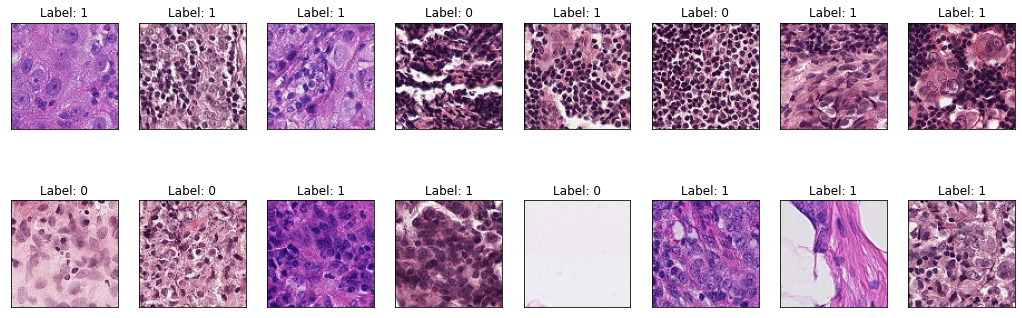

In [10]:
fig = plt.figure(figsize=(18, 6))
num_images = 16
train_imgs = os.listdir(train_dirname)
for idx, img in enumerate(np.random.choice(train_imgs, num_images)):
    ax = fig.add_subplot(2, num_images//2, idx+1, xticks=[], yticks=[])
    im = cv2.imread(os.path.join(train_dirname, img))
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    lab = train_labels.loc[train_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: {}'.format(lab))

As we can see, there are a huge variation of texture!

## 2. EDA

Lets look at the distribution of two labels.

In [11]:
labels_count = train_labels['label'].value_counts()

In [12]:
labels_count

0    130908
1     89117
Name: label, dtype: int64

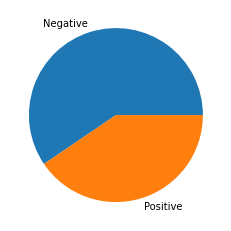

In [13]:
mylabels = ["Negative", "Positive"]

plt.pie(labels_count, labels = mylabels)
plt.show() 

The number of images in each class is not equal, but it is considered acceptable enough for training.

## 3. Model Architecture

my original simple model

In [ ]:

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

#model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
#model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation = 'softmax'))
#model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    #fill_mode='reflect',                               
    #rotation_range=15,
    rescale=1./255,
    #shear_range=0.2,
    zoom_range=0.1
)

In [15]:
train_batch_size = 16

In [16]:
train_gen = train_datagen.flow_from_directory('./histopathologic-cancer-detection/train_dir',
                                        target_size=(96, 96),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

Found 220025 images belonging to 2 classes.


In [ ]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("mymodel.h5", save_best_only=True)

In [17]:
len(train_labels['label'])

220025

In [18]:
int(np.ceil(len(train_labels['label']) / train_batch_size))

13752

In [ ]:
history = model.fit(train_gen, 
                    steps_per_epoch=int(np.ceil(len(train_labels['label']) / train_batch_size)), 
                    epochs=7,
                    callbacks=[modelCheckpoint]
                   )

Resnet based model

In [19]:
model_2 = tf.keras.applications.ResNet152V2(
    include_top=True,
    weights=None,
    input_shape=(96, 96, 3),
    classes=2,
    classifier_activation="softmax",
)

In [20]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
modelCheckpoint_2 = keras.callbacks.ModelCheckpoint("mymodel_2.h5", monitor="loss", save_best_only=True)

In [22]:
history_2 = model_2.fit(train_gen, 
                    steps_per_epoch=int(np.ceil(len(train_labels['label']) / train_batch_size)), 
                    epochs=7,
                    callbacks=[modelCheckpoint_2]
                   )

Epoch 1/7
13752/13752 [==============================] - 8202s 596ms/step - loss: 0.4567 - accuracy: 0.7939
Epoch 2/7
13752/13752 [==============================] - 8035s 584ms/step - loss: 0.3440 - accuracy: 0.8526
Epoch 3/7
13752/13752 [==============================] - 7998s 582ms/step - loss: 0.2923 - accuracy: 0.8793
Epoch 4/7
13752/13752 [==============================] - 7890s 574ms/step - loss: 0.2612 - accuracy: 0.8944
Epoch 5/7
13752/13752 [==============================] - 7705s 560ms/step - loss: 0.2413 - accuracy: 0.9043
Epoch 6/7
13752/13752 [==============================] - 7486s 544ms/step - loss: 0.2276 - accuracy: 0.9106
Epoch 7/7
13752/13752 [==============================] - 7794s 567ms/step - loss: 0.2159 - accuracy: 0.9161


In [25]:
loss_history = history_2.history["loss"]
acc_history = history_2.history["accuracy"]

In [28]:
numpy_loss_history = np.array(loss_history)
np.savetxt("loss_history.txt", numpy_loss_history, delimiter=",")
numpy_acc_history = np.array(acc_history)
np.savetxt("acc_history.txt", numpy_acc_history, delimiter=",")

## 4 Results and Analysis


The graphs of loss and accuracy

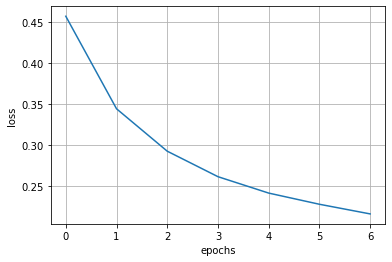

In [5]:
loss_data = np.loadtxt("loss_history.txt")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(loss_data);

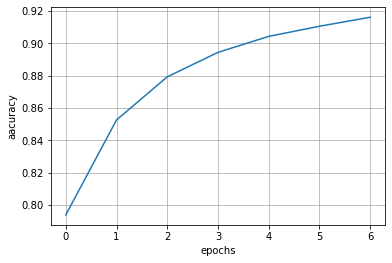

In [6]:
acc_data = np.loadtxt("acc_history.txt")
plt.xlabel('epochs')
plt.ylabel('aacuracy')
plt.grid()
plt.plot(acc_data);

In [2]:
infer_model = keras.models.load_model("./mymodel_2.h5")

In [18]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_gen = test_datagen.flow_from_directory('./histopathologic-cancer-detection/test_dir',
                                        target_size=(96, 96),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [19]:
num_test_images = 57458
predictions = infer_model.predict(test_gen, steps=num_test_images, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
57458/57458 [==============================] - 1443s 25ms/step


In [20]:
len(predictions)

57458

In [32]:
df_preds = pd.DataFrame(predictions, columns=['nega', 'posi'])
df_preds.head()

,nega,posi
0,0.768522,0.231478
1,0.707709,0.292291
2,0.870252,0.129748
3,0.997421,0.002579
4,0.991865,0.008135


In [33]:
test_filenames = test_gen.filenames
df_preds['file_names'] = test_filenames
df_preds.head()

,nega,posi,file_names
0,0.768522,0.231478,test\00006537328c33e284c973d7b39d340809f7271b.tif
1,0.707709,0.292291,test\0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,0.870252,0.129748,test\00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,0.997421,0.002579,test\000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,0.991865,0.008135,test\000270442cc15af719583a8172c87cd2bd9c7746.tif


In [34]:
def get_filename(x):
    return os.path.basename(x).split('.')[0]

In [35]:
df_preds['id'] = df_preds['file_names'].apply(get_filename)

df_preds.head()

,nega,posi,file_names,id
0,0.768522,0.231478,test\00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,0.707709,0.292291,test\0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.870252,0.129748,test\00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.997421,0.002579,test\000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.991865,0.008135,test\000270442cc15af719583a8172c87cd2bd9c7746.tif,000270442cc15af719583a8172c87cd2bd9c7746


In [36]:
y_pred = df_preds['posi']
image_id = df_preds['id']

In [37]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('my_submission.csv', columns=['label']) 
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.231478
0000ec92553fda4ce39889f9226ace43cae3364e,0.292291
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.129748
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.002579
000270442cc15af719583a8172c87cd2bd9c7746,0.008135


### My result on kaggle

![LB](./LB_1.png)

## 5 Conclusion
I got the score at 0.8538 in this task, but there are much more rooms to improve it. Here are some ideas that I should consider; 
 - (i) Search other models
 - (ii) Tune the hyper parameters
 - (iii) Transfer Learning
 - (iv) Apply bigger images
 
(i) and (ii) are common approach that we should try to improve the CNN model. In other hand, (iii) and (iv) are rather  technical approach. I learned about the transfer learning in the lesson and it said there are some conditions to apply this technique; such as "New data set must be large and similar to the original dataset" and ""New data set must be large and and very different from the original dataset".  I need to take it in account for the transfer learning approach. And then I had to resize images to smaller ones because I do not have enough machine resource to perform the CNN training with the original image size. It is considered that a resized image lost some information and it would affect the performance of model predictions. Thus I should have used the high-end machine as much as possible to get better results.